In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [9]:
import pandas as pd
data = pd.read_csv("ClassroomRole.csv")

data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})
data['HairType'] = data['HairType'].map({'Short': 0, 'Medium': 1,"Long":2,"Very-Long":3})
data['ClasroomRole'] = data['ClasroomRole'].map({'Student': 0, 'Teacher': 1})

x= data.iloc[:,2:5]
y = data.iloc[:,5]
scaler = MinMaxScaler()

scaler.fit(x)

# Transform the data
X = scaler.transform(x)

X = np.array(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_train.shape

(800, 3)

In [54]:
model = Sequential([
    Dense(2, activation='sigmoid', input_dim=X_train.shape[1]),  # 3 -> 2
    Dense(1, activation='sigmoid'),              # 2 -> 1
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, verbose=0)


In [ ]:

def sigmoid_inv(y):
    y = np.clip(y, 1e-7, 1 - 1e-7)  # To avoid division by zero
    return -np.log(1 / y - 1)





In [ ]:
def inverse_layer_general(weights, biases, outputs, free_vars=None):
    """
    Generalized inversion for a single layer of a neural network.
    Args:
        weights (np.ndarray): Weight matrix of shape (output_size, input_size).
        biases (np.ndarray): Bias vector of shape (output_size,).
        outputs (np.ndarray): Desired output vector of shape (output_size,).
        free_vars (np.ndarray): Free variables for dimension mismatch (optional).
    Returns:
        np.ndarray: Input vector for the layer.
    """
 
    z = sigmoid_inv(outputs)  # Adjust for other activation functions if needed

    # Handle dimension mismatch (free variables)
    output_size, input_size = weights.shape
    if input_size > output_size:  # More inputs than outputs
        extra_weights = weights[:, output_size:]
        if free_vars is None:
            raise ValueError("Free variables required for size mismatch.")
        z -= np.dot(extra_weights, free_vars)
        weights = weights[:, :output_size]  # Keep only relevant columns

    # Solve the linear system
    inputs, _, _, _ = np.linalg.lstsq(weights, z - biases, rcond=None)
    return inputs

In [52]:
def generate_manifold(model, target_output, free_variable_range=(-1, 1), num_samples=100):
    """
    Generate a manifold of inputs for a given target output by iterating over free variables.
    Args:
        model (list): A list of (weights, biases) tuples for each layer of the neural network.
        target_output (np.ndarray): Target output vector for the final layer.
        free_variable_range (tuple): Range for free variables (min, max).
        num_samples (int): Number of samples to generate for free variables.
    Returns:
        np.ndarray: Array of input vectors forming the manifold.
    """
    # Generate free variable samples
    free_var_samples = np.linspace(free_variable_range[0], free_variable_range[1], num_samples)
    input_manifold = []

    for free_var in free_var_samples:
        free_vars = np.array([free_var])  # Adjust if multiple free variables needed
        current_output = target_output

        # Backpropagate through each layer
        for weights, biases in reversed(model):
            current_output = inverse_layer_general(weights, biases, current_output, free_vars)

        input_manifold.append(current_output)

    return np.array(input_manifold)


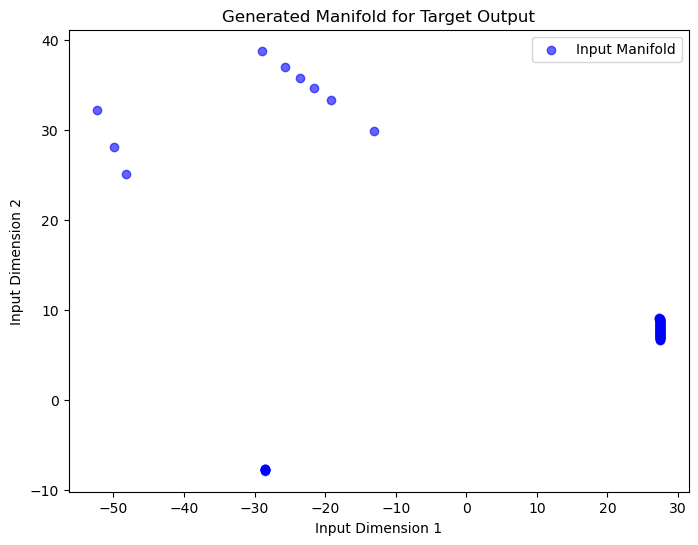

In [56]:


#a simple 3-layer neural network (weights and biases)
model = [
    (np.array([[0.5, 0.3, 0.2], [0.4, 0.7, 0.5]]), np.array([0.1, -0.2])),  # Layer 1
    (np.array([[0.6, 0.4], [0.3, 0.5]]), np.array([0.2, 0.1])),             # Layer 2
    (np.array([[0.7, 0.8]]), np.array([-0.3]))                             # Layer 3 (output layer)
]

# Target output and manifold generation
target_output = np.array([0.8])  # output value for the final layer to invernse
manifold = generate_manifold(model, target_output, free_variable_range=(-2, 2), num_samples=100)

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(manifold[:, 0], manifold[:, 1], c='blue', alpha=0.6, label='Input Manifold')
plt.xlabel('Input Dimension 1')
plt.ylabel('Input Dimension 2')
plt.title('Generated Manifold for Target Output')
plt.legend()
plt.show()
